# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
#!pip install phik 
#!pip install shap 
#!pip install --upgrade shap 
#!pip install --upgrade numba 
#!pip install seaborn==0.13.2
#!pip install imbalanced-learn==0.10.1 
#!pip install scikit-learn==1.2.2 
#!pip install xgboost
#!pip install lightgbm

In [2]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, mean_squared_error

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.compose import ColumnTransformer

# загружаем нужные модели
from lightgbm import LGBMRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import ydata_profiling

In [3]:
try:
    cars = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
except:
    cars = pd.read_csv('autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])   

**Признаки**

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**

- Price — цена (евро)

## Подготовка данных

In [4]:
cars.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [5]:
cars.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

Видим, что надо преобразовать дату из object в datetime

In [6]:
cars.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Видим много пропусков в столбцах: VehicleType, Gearbox, Model, FuelType, Repaired

## Предобработка данных

### Столбцы к нижнему регистру

In [7]:
cars.columns = cars.columns.str.lower().str.replace(' ', '_')
cars.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'repaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

### Дубликаты

In [8]:
cars.duplicated().sum()

4

4 полных дубликата

In [9]:
cars[cars.duplicated()]

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15


In [10]:
cars = cars.drop_duplicates()

In [11]:
for column in cars.select_dtypes(include='object').columns:
        print(column)
        print(cars[column].unique())

vehicletype
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
gearbox
['manual' 'auto' nan]
model
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore'

Не видим явных дубликатов

### Обработка пропусков

In [12]:
cars.isnull().sum()

datecrawled              0
price                    0
vehicletype          37490
registrationyear         0
gearbox              19833
power                    0
model                19705
kilometer                0
registrationmonth        0
fueltype             32895
brand                    0
repaired             71154
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

Видим много пропусков в столбцах: VehicleType, Gearbox, Model, FuelType, Repaired

In [13]:
cars.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


Видим, что можем удалить 0.6% 

In [14]:
cars2 = cars.query("gearbox.isna() and vehicletype.isna() and model.isna() and fueltype.isna() and repaired.isna()")
cars2['datecrawled'].count(),cars['datecrawled'].count(),(cars2['datecrawled'].count()/cars['datecrawled'].count())*100

(2237, 354365, 0.6312700182015718)

In [15]:
cars2 = cars.query("not(gearbox.isna() and vehicletype.isna() and model.isna() and fueltype.isna() and repaired.isna())")
cars2.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


**Вывод:**
- Привели столбцы к нижнему регистру
- Удалили 4 полных дубликата
- Нет явных дубликатов
- удалили 0.6% от общих - строки с пропусками во всех 5ти колонках

## Исследовательский анализ данных

In [16]:
len(cars2.columns)

16

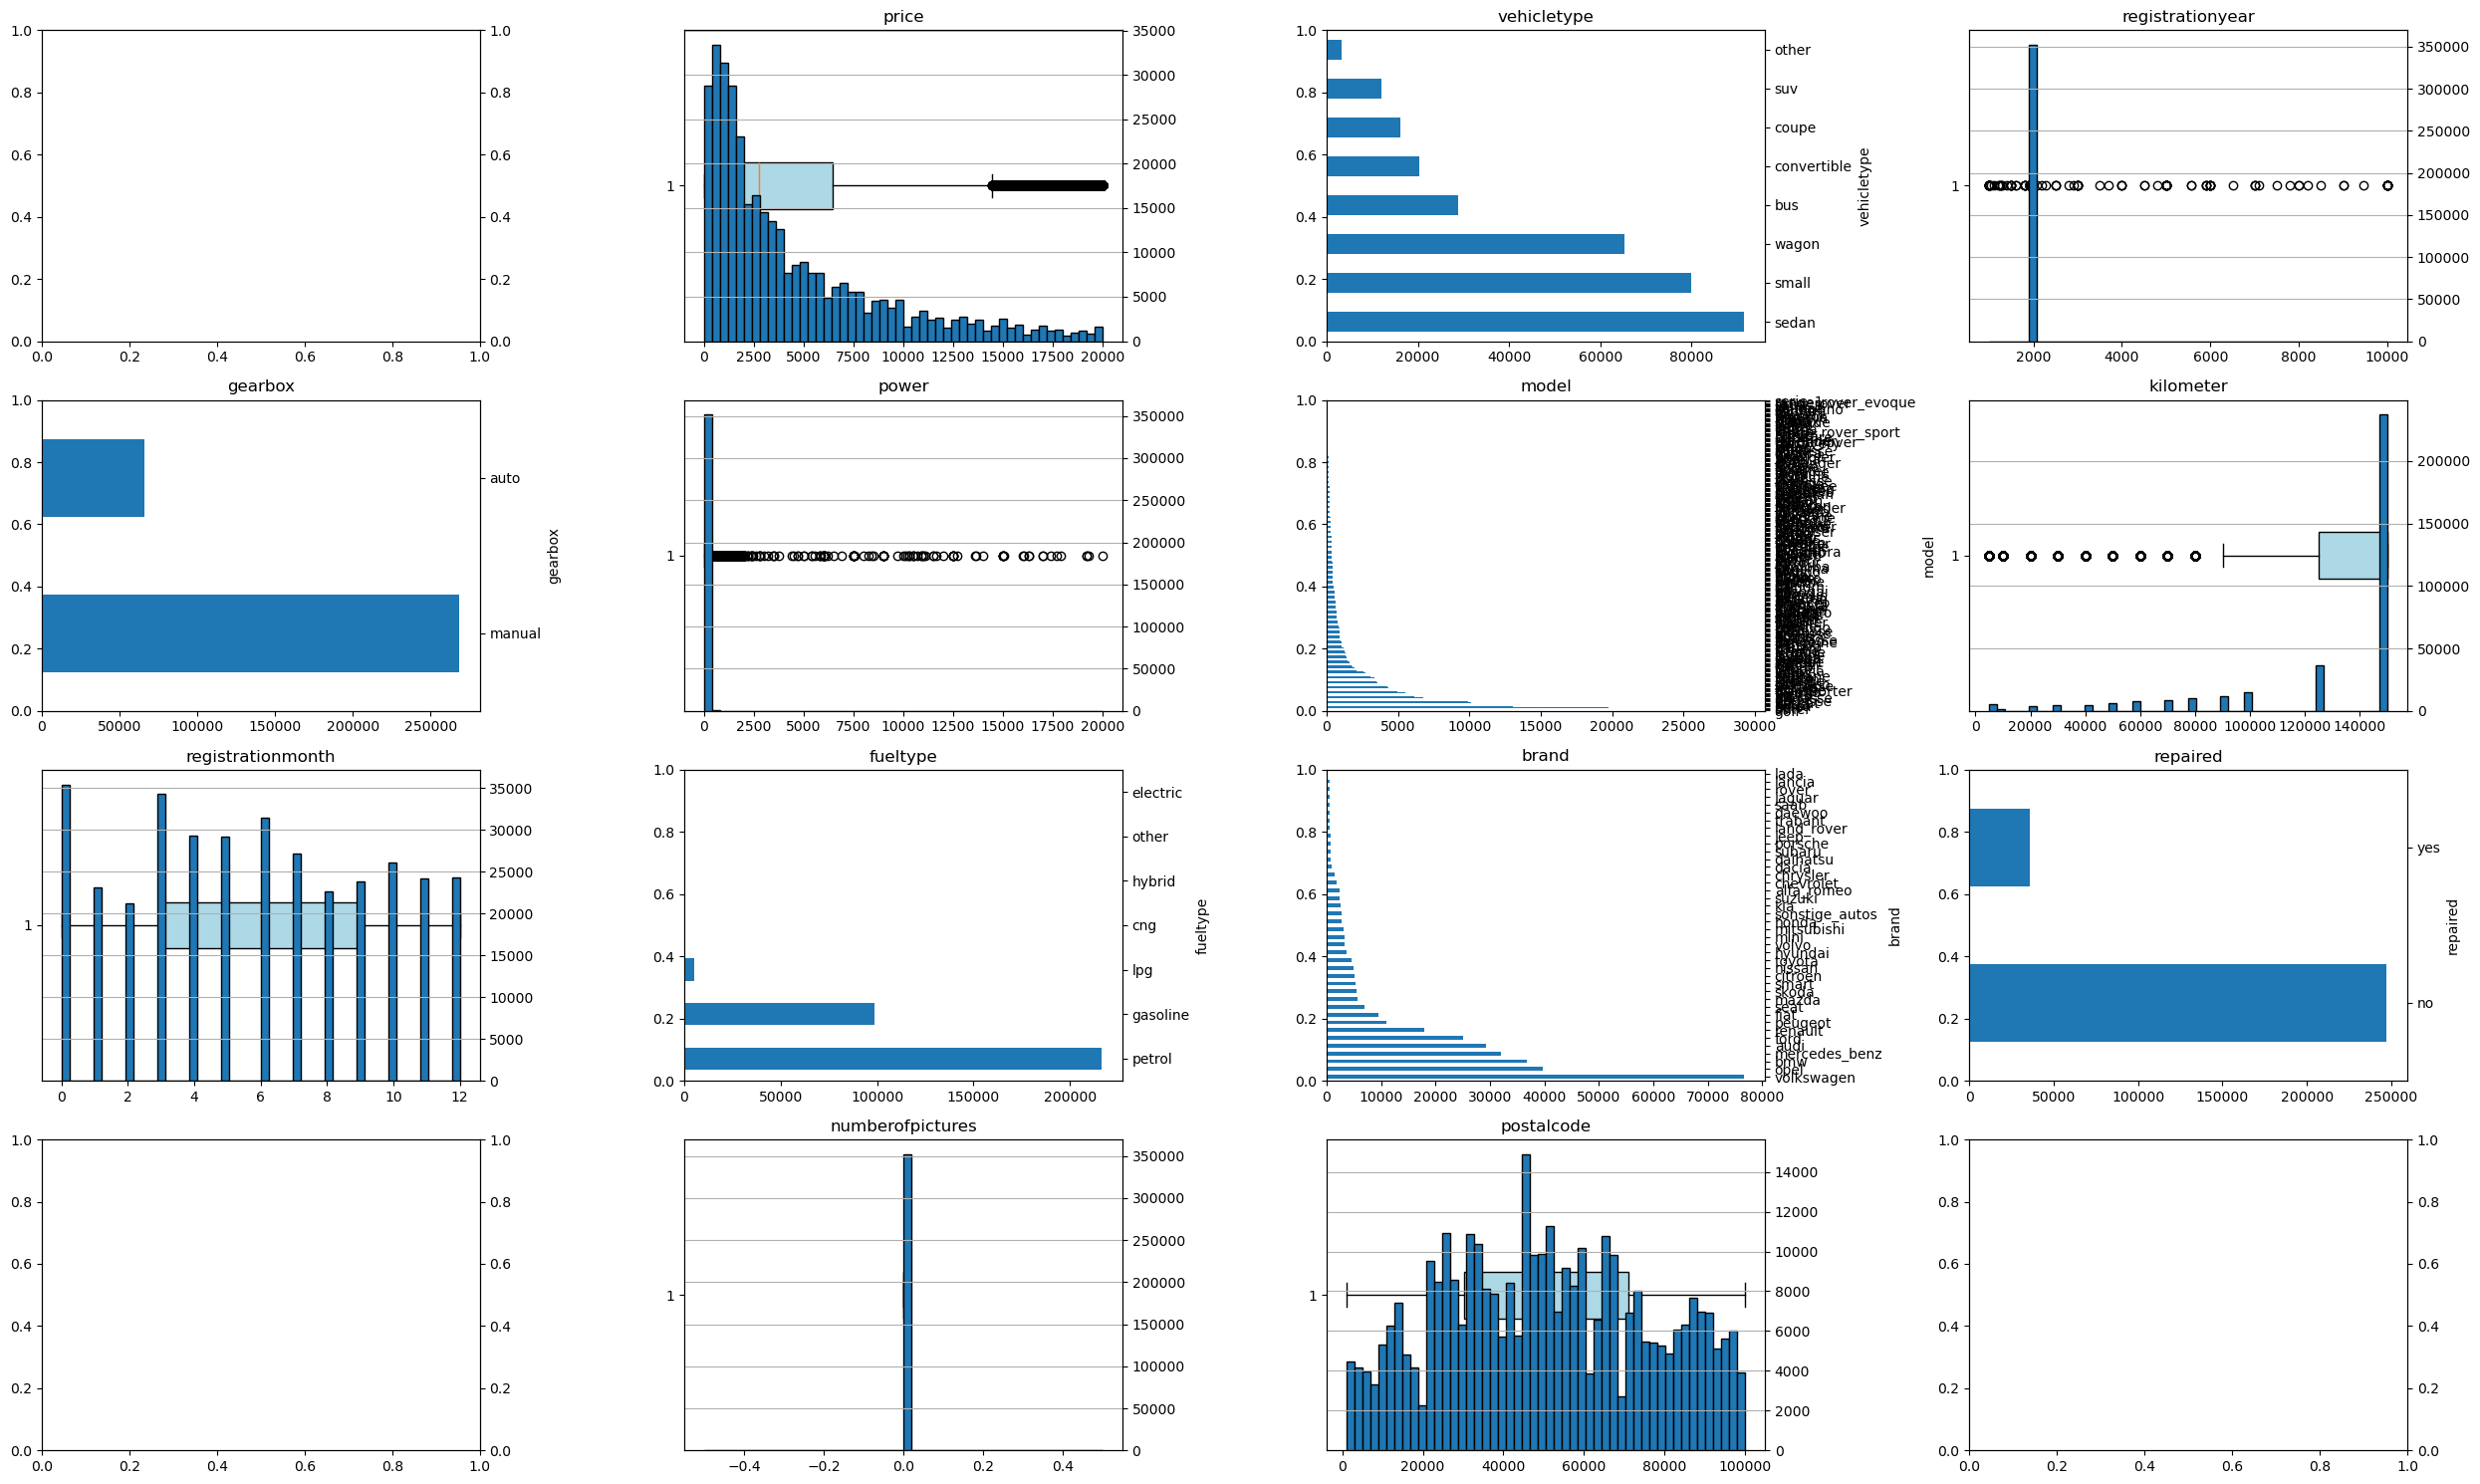

In [17]:
fig = plt.figure(figsize=(25, 15))
for i, column in enumerate(cars2.columns):
    ax = fig.add_subplot(4, 4, i + 1)
    ax_hist = ax.twinx()  
    if cars2[column].dtype == 'object':
        cars2[column].value_counts().plot(kind='barh')
        plt.title(column)
    elif cars2[column].dtype == 'int64':
        cars2[column].hist(bins = 50, ec='black')
        ax.boxplot(cars2[column], vert=False, patch_artist=True, boxprops={'facecolor': 'lightblue'})
        plt.title(column)

plt.tight_layout()  # Автоматически подгоняем размер подграфиков для лучшей компоновки
plt.show()  # Отображаем графики

In [18]:
cars2.describe()

,datecrawled,price,registrationyear,power,kilometer,registrationmonth,datecreated,numberofpictures,postalcode,lastseen
count,352128,352128.000000,352128.000000,352128.000000,352128.000000,352128.000000,352128,352128.0,352128.000000,352128
mean,2016-03-21 12:58:07.762327808,4437.564008,2003.871666,110.719591,128438.266767,5.746427,2016-03-20 19:11:25.796073728,0.0,50534.702262,2016-03-29 23:57:15.855850752
min,2016-03-05 14:06:22,0.000000,1000.000000,0.000000,5000.000000,0.000000,2014-03-10 00:00:00,0.0,1067.000000,2016-03-05 14:15:08
25%,2016-03-13 11:51:32.500000,1100.000000,1999.000000,69.000000,125000.000000,3.000000,2016-03-13 00:00:00,0.0,30167.000000,2016-03-23 02:51:02.500000
50%,2016-03-21 17:51:13,2750.000000,2003.000000,105.000000,150000.000000,6.000000,2016-03-21 00:00:00,0.0,49429.000000,2016-04-03 15:18:13.500000
75%,2016-03-29 14:38:15.249999872,6450.000000,2008.000000,143.000000,150000.000000,9.000000,2016-03-29 00:00:00,0.0,71093.000000,2016-04-06 10:15:26
max,2016-04-07 14:36:58,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,2016-04-07 00:00:00,0.0,99998.000000,2016-04-07 14:58:51
std,NaN,4516.558304,70.673831,190.250602,37562.630095,3.712300,NaN,0.0,25778.997975,NaN


Видим аномальные значение в registrationyear

In [19]:
cars2['registrationyear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988,
       1965, 1970, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967, 1959,
       1956, 1000, 1941, 9999, 1500, 2200, 1962, 1929, 1957, 1940, 3000,
       2066, 1949, 2019, 1937, 1951, 1800, 1953, 8000, 9000, 2900, 6000,
       5900, 5911, 1933, 1400, 1950, 4000, 1948, 1952, 1200, 8500, 1932,
       3700, 4800, 1942, 1935, 1234, 1936, 6500, 1923, 2290, 1930, 1001,
       9450, 1944, 7000, 2500, 1943, 1934, 1938, 1928, 1919, 5555, 1039,
       1300, 2800, 1931, 1915, 4500, 1920, 1602, 1111, 7800, 1947, 1927,
       7100, 8200, 1946, 7500, 3500, 1600], dtype=int64)

In [20]:
cars2.query('(registrationyear>2024 and 1700<registrationyear)')['registrationmonth'].count()/cars['datecrawled'].count()

0.00020882423489904477

In [21]:
cars2 = cars2.query('not (registrationyear>2024 and 1700<registrationyear)')
cars2.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [22]:
cars2['registrationmonth'].unique()

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9], dtype=int64)

In [23]:
cars2.query('registrationmonth == 0')['datecrawled'].count()/cars['datecrawled'].count()

0.09977283309581929

In [24]:
cars2['datecrawled'].count()/cars['datecrawled'].count()

0.9934784755830852

In [25]:
cars2.query('price == 0')['registrationmonth'].count()/cars['datecrawled'].count()

0.028312615523542112

In [26]:
cars2 = cars2.query('not price == 0')

аномальное значение - не бывает 0 месяца

**Вывод:**
- удалили аномальные значения в столбце registrationyear - 0 месяц
- удалили машины, которые отдают бесплатно (чтобы они не влияли на основные данные)
- так же видим аномальные значения в столбце registrationmonth, но мы не можем их удалить, так как >10% от общих данных
- Видим, что некоторые машины продаются без двигателя

## Создание нового столбца

In [27]:
cars2['registrationyear'].describe()

count    342021.000000
mean       2003.107768
std          11.442222
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: registrationyear, dtype: float64

In [28]:
def cars_year(year):
    if year < 1990:
        return 'супер-ретро'
    elif year >= 1990 and year < 2003:
        return 'ретро'
    elif year < 2010 and year >= 2003:
        return 'старая'
    else:
        return 'новая'

cars2['typecar'] = cars2['registrationyear'].apply(cars_year) 
cars2['typecar']

0          ретро
1          новая
2         старая
3          ретро
4         старая
           ...  
354362    старая
354363     ретро
354366     ретро
354367     ретро
354368     ретро
Name: typecar, Length: 342021, dtype: object

In [29]:
cars2['typecar'].value_counts()

typecar
ретро          148949
старая         126476
новая           57829
супер-ретро      8767
Name: count, dtype: int64

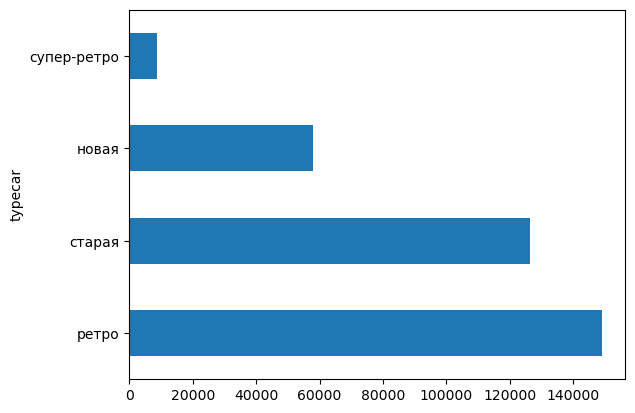

In [30]:
cars2['typecar'].value_counts().plot(kind='barh');

## Корреляционный анализ

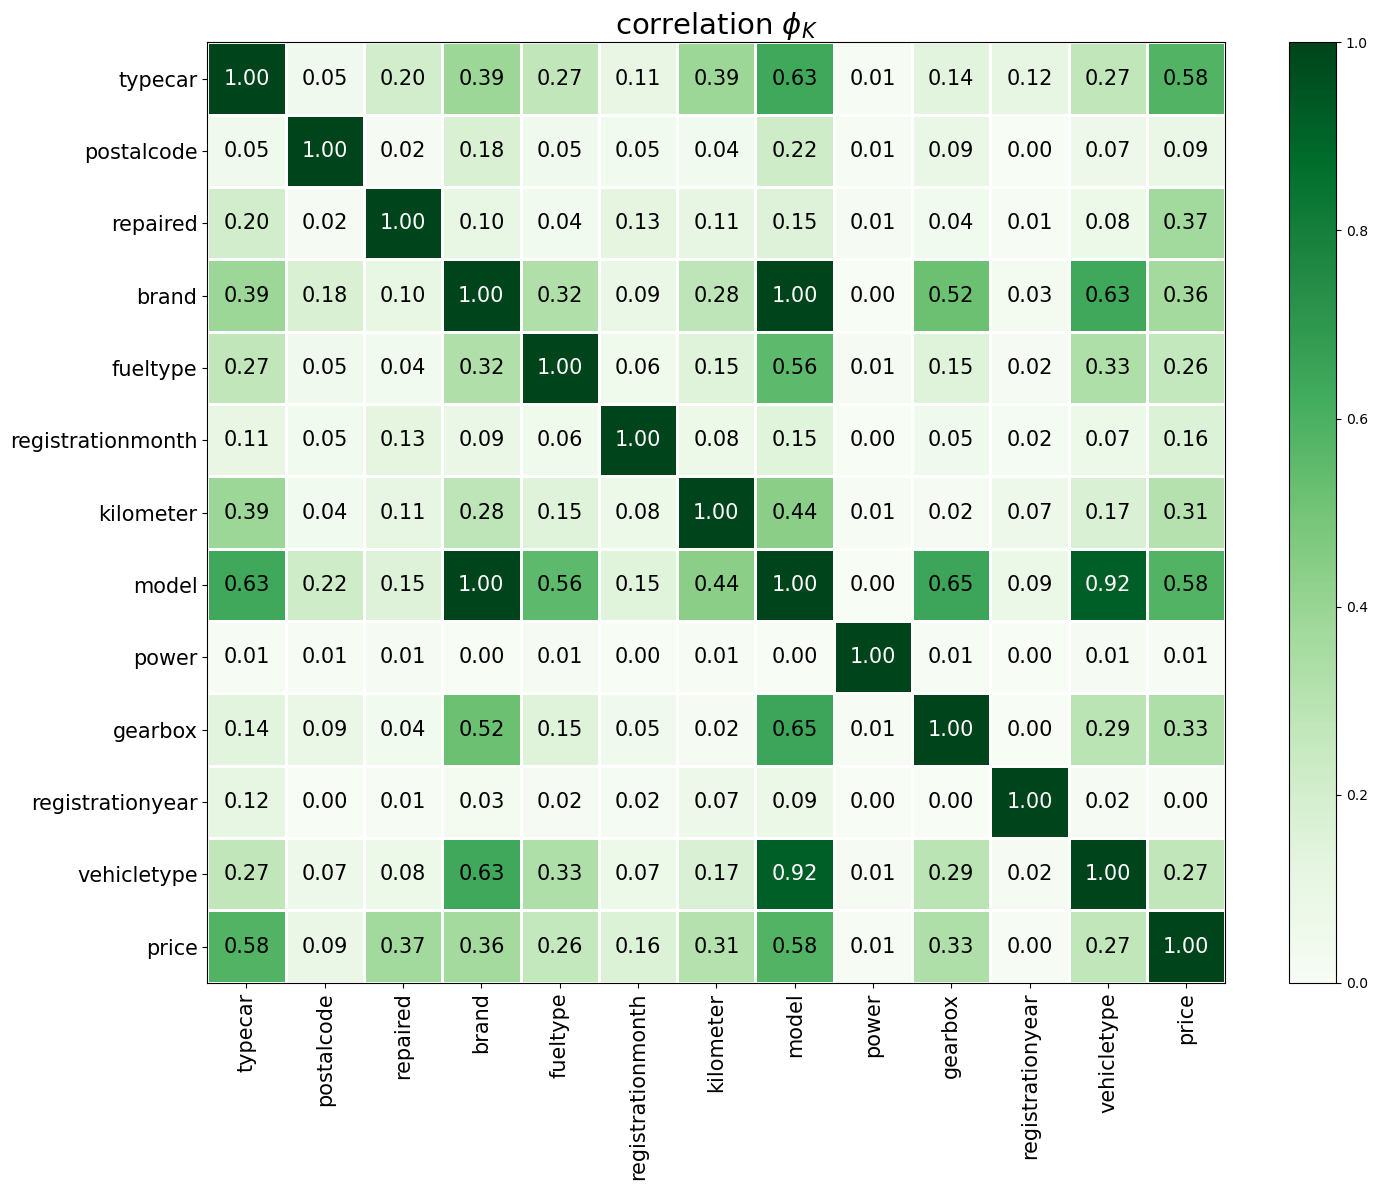

In [31]:
cars2 = cars2.drop(['numberofpictures'], axis=1)
cars2 = cars2.drop('datecrawled',axis = 1)
cars2 = cars2.drop('datecreated',axis = 1)
cars2 = cars2.drop('lastseen',axis = 1)
#cars2 = cars2.drop('typecar',axis = 1)
interval_cols = cars2.select_dtypes(include = ['int','float'])

phik_overview = cars2.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    vmin=0, vmax=1, color_map='Greens',
    fontsize_factor=1.5,
    figsize=(15, 12)
)

Видим:
- 100% - мультиколлинеарность модели с брендом
- 92% - модель с  тип автомобильного кузова

## Обучение моделей

In [32]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
y = cars2['price']
X = cars2.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)#,stratify=y)

ord_columns = ['vehicletype','fueltype','brand','model']
ohe_columns = [col for col in cars2.select_dtypes(include = 'object').columns.tolist() if col not in  ord_columns]
num_columns = [col for col in cars2.select_dtypes(include = 'int').columns.tolist() if col!='price']


ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord', OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value = np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

# Создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),    
      ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore',sparse_output= False))])

# Создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
    ('num', MinMaxScaler(), num_columns),
    ('ord', ord_pipe, ord_columns)], remainder='passthrough')

# Создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())])

param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 9),
        'models__min_samples_leaf':range(2, 9),
        'models__min_samples_split':range(2, 9),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    {'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 200],  
        'models__learning_rate': [0.1, 0.01],  
        'models__max_depth': range(2, 6),  
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]},
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)


In [33]:
%%time
# 6. Обучение модели
randomized_search.fit(X_train, y_train)

# 7. Вывод результатов
print(f"Лучшие параметры: {randomized_search.best_estimator_}")
print(f"Лучший RMSE на тренировочных: {randomized_search.best_score_* -1}")


Лучшие параметры: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gearbox', 'repaired',
                                                   'typecar']),
                                                 ('num', RobustScaler(),
                                           

## Анализ моделей

In [34]:
randomized_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gearbox', 'repaired',
                                                   'typecar']),
                                                 ('num', RobustScaler(),
                                                  ['registrationyear', 'power',
                                                   'kilometer'...
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['vehicletype', 'fueltype',
                                                   'brand', 'model'])])),
                ('models',
                 DecisionTreeRegressor(max_depth=8, min_samples_leaf=4,
                                       min_samples_split=3, random_state=42))])

In [35]:
best_model = randomized_search.best_estimator_
final_estimator = best_model.named_steps['models'] 

feature_importances = final_estimator.feature_importances_ 

feature_names = best_model.named_steps['preprocessor'].named_transformers_['ohe'].get_feature_names_out(ohe_columns) 
feature_names = np.concatenate((feature_names, num_columns, ord_columns))

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df.sort_values('Importance', ascending=False)

,Feature,Importance
5,registrationyear,0.495415
6,power,0.314854
3,typecar_старая,0.049150
7,kilometer,0.048069
2,typecar_ретро,0.045230
10,vehicletype,0.020645
12,brand,0.009971
1,repaired_yes,0.006993
13,model,0.003585
11,fueltype,0.003219


новый столбец положительно повлиял на модель

In [36]:
results = pd.DataFrame(randomized_search.cv_results_).set_index('param_models')
display(results[['rank_test_score','params', 'mean_fit_time','mean_score_time',
                 'mean_test_score']].sort_values(by='rank_test_score').head(20))

,rank_test_score,params,mean_fit_time,mean_score_time,mean_test_score
param_models,,,,,
DecisionTreeRegressor(random_state=42),1,"{'preprocessor__num': RobustScaler(), 'models_...",2.336759,0.181249,-2160.340419
DecisionTreeRegressor(random_state=42),2,"{'preprocessor__num': RobustScaler(), 'models_...",2.254821,0.214089,-2160.570760
DecisionTreeRegressor(random_state=42),3,"{'preprocessor__num': 'passthrough', 'models__...",2.080717,0.183851,-2242.655474
DecisionTreeRegressor(random_state=42),4,"{'preprocessor__num': RobustScaler(), 'models_...",2.075237,0.190960,-2242.701398
DecisionTreeRegressor(random_state=42),4,"{'preprocessor__num': RobustScaler(), 'models_...",2.171496,0.216444,-2242.701398
DecisionTreeRegressor(random_state=42),6,"{'preprocessor__num': StandardScaler(), 'model...",2.137598,0.201921,-2242.748813
DecisionTreeRegressor(random_state=42),7,"{'preprocessor__num': StandardScaler(), 'model...",2.010940,0.200260,-2345.939646
DecisionTreeRegressor(random_state=42),8,"{'preprocessor__num': RobustScaler(), 'models_...",1.923664,0.219887,-2669.406085
DecisionTreeRegressor(random_state=42),9,"{'preprocessor__num': RobustScaler(), 'models_...",1.535503,0.142555,-2944.497728


Видим, что самая лучшая модель по рангу:

|модель|
|---|
|DecisionTreeRegressor(max_depth=8, min_samples_leaf=4, min_samples_split=3,random_state=42)|

- Насколько точная mean_test_score = 2169
- Насколько быстрая в обучении mean_fit_time = 1.076761
- Насколько быстрая в предсказании  mean_score_time = 0.081893	

Найдем самую быструю модель

In [37]:
results = pd.DataFrame(randomized_search.cv_results_).set_index('param_models')
display(results[['mean_fit_time','mean_score_time',
                 'mean_test_score']].sort_values(by=['mean_fit_time','mean_score_time'],ascending = True).head(20))

,mean_fit_time,mean_score_time,mean_test_score
param_models,,,
DecisionTreeRegressor(random_state=42),1.535503,0.142555,-2944.497728
DecisionTreeRegressor(random_state=42),1.551377,0.204002,-3266.374118
DecisionTreeRegressor(random_state=42),1.923664,0.219887,-2669.406085
DecisionTreeRegressor(random_state=42),2.010940,0.200260,-2345.939646
DecisionTreeRegressor(random_state=42),2.075237,0.190960,-2242.701398
DecisionTreeRegressor(random_state=42),2.080717,0.183851,-2242.655474
DecisionTreeRegressor(random_state=42),2.137598,0.201921,-2242.748813
DecisionTreeRegressor(random_state=42),2.171496,0.216444,-2242.701398
DecisionTreeRegressor(random_state=42),2.254821,0.214089,-2160.570760


Так как значение метрики RMSE должно быть меньше 2500:
<center>Самая быстрая модель:</center>

|param_models |mean_fit_time | mean_score_time | mean_test_score|
|---|---|---|---|
|DecisionTreeRegressor(max_depth=8, min_samples_leaf=4, min_samples_split=3, random_state=42)|0.966854 |	0.084699 | -2358.575021|

Видим что rmse - больше, но при этом время затраченное на обучение и предсказание - гораздо меньше

In [38]:
%%time
# 8. Оценка модели на тестовом наборе
y_test_pred2 = randomized_search.predict(X_test)
print(f"Лучший RMSE на тестовых: {sqrt(mean_squared_error(y_test, y_test_pred2))}")

Лучший RMSE на тестовых: 2163.623318699389
CPU times: total: 109 ms
Wall time: 132 ms


**Вывод:**
- Используя модели дерева решений, линейную регрессию и модель с бустингом нашли лучшую модель по всем параметрам
- Нашли самую быструю модель по требованию заказчика

## Вывод

- Выволнили подготовку данных

1. Предобработка данных

- Привели столбцы к нижнему регистру
- Удалили 4 полных дубликата
- Нет явных дубликатов
- удалили 0.6% от общих - строки с пропусками во всех 5ти колонках

2. Исследовательский анализ данных

- удалили аномальные значения в столбце registrationyear - 0 месяц
- удалили машины, которые отдают бесплатно (чтобы они не влияли на основные данные)
- так же видим аномальные значения в столбце registrationmonth, но мы не можем их удалить, так как >10% от общих данных
- Видим, что некоторые машины продаются без двигателя

3. Корреляционный анализ

- 100% - мультиколлинеарность модели с брендом
- 92% - модель с  тип автомобильного кузова

4. Анализ моделей

Видим, что самая лучшая модель по рангу:

|модель|
|---|
|DecisionTreeRegressor(max_depth=8, min_samples_leaf=4, min_samples_split=3,random_state=42)|

- Насколько точная mean_test_score = 2169
- Насколько быстрая в обучении mean_fit_time = 1.076761
- Насколько быстрая в предсказании  mean_score_time = 0.081893	


Так как значение метрики RMSE должно быть меньше 2500:
<center>Самая быстрая модель:</center>

|param_models |mean_fit_time | mean_score_time | mean_test_score|
|---|---|---|---|
|DecisionTreeRegressor(max_depth=8, min_samples_leaf=4, min_samples_split=3,\n random_state=42)|0.966854 |	0.084699 | -2358.575021|

Видим что rmse - больше, но при этом время затраченное на обучение и предсказание - гораздо меньше

- Используя модели дерева решений, линейную регрессию и модель с бустингом нашли лучшую модель по всем параметрам
- Нашли самую быструю модель по требованию заказчика